# Installs & Imports

In [1]:
!pip install -q seaborn scikit-learn joblib flask gunicorn librosa tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import random
import joblib
import pickle
import shutil
from IPython import display as ipd

import librosa
from librosa import display

import tensorflow as tf
import keras

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

2024-02-29 07:48:31.276898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Get versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Librosa version: {librosa.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Python version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
NumPy version: 1.26.3
Pandas version: 2.1.4
Librosa version: 0.10.1
TensorFlow version: 2.12.1
Keras version: 2.12.0
Scikit-learn version: 1.3.2


# Loading the Data

In [4]:
# Loading the full UrbanSounds8k dataset used up all available space
# Therefore, we will use the .pkl file of the data from after preprocessing
# (resampling, padding, and binarizing the labels) and feature extraction
with open('features_data.pkl', 'rb') as file:
    features_data = pickle.load(file)

In [5]:
# Create feature names
n_mfcc = 13
n_chroma = 12
n_spectral_contrast = 7

mfcc_feature_names = [f"MFCC_{i+1}" for i in range(n_mfcc)]
spectral_contrast_feature_names = [f"SpectralContrast_{i+1}" for i in range(n_spectral_contrast)]
chroma_feature_names = [f"Chroma_{i+1}" for i in range(n_chroma)]
single_value_feature_names = ['ZCR', 'SpectralCentroid', 'SpectralRolloff', 'MelSpectrogram', 'AttackTime', 'DecayTime']

feature_names = mfcc_feature_names + single_value_feature_names + spectral_contrast_feature_names + chroma_feature_names

In [6]:
# Set columns to maximum
pd.set_option('display.max_columns', None)

# Prepare data for DataFrame creation
data_for_df = []

for item in features_data:
    features_dict = {f_name: f_val for f_name, f_val in zip(feature_names, item['features'])}
    features_dict['Label'] = item['label']
    data_for_df.append(features_dict)

# Create DataFrame
features_df = pd.DataFrame(data_for_df)

# Display the DataFrame
features_df.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,ZCR,SpectralCentroid,SpectralRolloff,MelSpectrogram,AttackTime,DecayTime,SpectralContrast_1,SpectralContrast_2,SpectralContrast_3,SpectralContrast_4,SpectralContrast_5,SpectralContrast_6,SpectralContrast_7,Chroma_1,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,Chroma_7,Chroma_8,Chroma_9,Chroma_10,Chroma_11,Chroma_12,Label
0,-360.428711,101.799385,-48.452560,19.529387,-38.798157,-2.762234,-19.598938,-0.748570,-9.297232,0.005592,-6.235853,3.855452,-7.079578,0.131294,2157.843464,4073.260533,0.015638,33.600283,14.510648,18.314453,19.189440,18.897433,19.316690,52.272584,0.302249,0.370210,0.398669,0.403678,0.409805,0.419761,0.520074,0.399364,0.333400,0.209773,0.230499,0.236642,2.345215,1.654785,0
1,-514.698181,26.070553,-39.440971,15.977687,-11.840044,4.835781,-8.802161,1.941157,-4.388472,-1.307502,-3.835765,0.452041,-0.429392,0.060538,824.628926,1333.378257,0.650767,8.434165,7.026992,7.455770,7.543952,7.961006,11.518813,21.385842,0.250509,0.256086,0.210101,0.168845,0.148668,0.137492,0.140484,0.152970,0.168971,0.159580,0.178737,0.233685,0.069660,3.930340,1
2,-195.779236,71.543922,-21.708836,53.107872,25.810648,17.948709,5.881225,9.549773,-3.258073,10.100700,19.029978,-1.886575,8.154268,0.096132,2237.854886,4577.859409,0.660452,15.804524,10.413192,13.944489,15.547130,15.943534,18.985393,43.743110,0.519965,0.466049,0.493235,0.552868,0.601802,0.772894,0.809187,0.684383,0.541798,0.451651,0.463271,0.506475,0.325079,3.674921,0
3,-192.423386,179.148453,2.353148,5.435854,-2.074950,-4.626775,-12.023396,7.782510,-15.510917,-0.380375,-9.807850,-6.300093,-20.871683,0.038470,901.999151,1362.877501,2.341649,25.592470,11.025404,14.647796,15.159430,16.767774,16.237821,46.456960,0.351737,0.308191,0.305249,0.369529,0.509951,0.741404,0.819406,0.623610,0.527260,0.501138,0.454938,0.413126,0.069660,3.930340,0
4,-253.106689,31.868446,-7.825550,23.297758,-4.329890,19.634998,-9.299934,16.484146,-7.474760,8.338264,2.456118,12.483587,-2.474160,0.181787,2719.328313,5101.999977,0.454015,18.514591,12.685586,13.820820,14.145793,14.695049,15.709661,43.256920,0.528077,0.494636,0.503364,0.519524,0.636063,0.580882,0.457143,0.429452,0.443312,0.460302,0.460294,0.529355,0.069660,3.930340,0


In [7]:
# Examine shapes
features_df.shape

(8732, 39)

# Exploring the Data

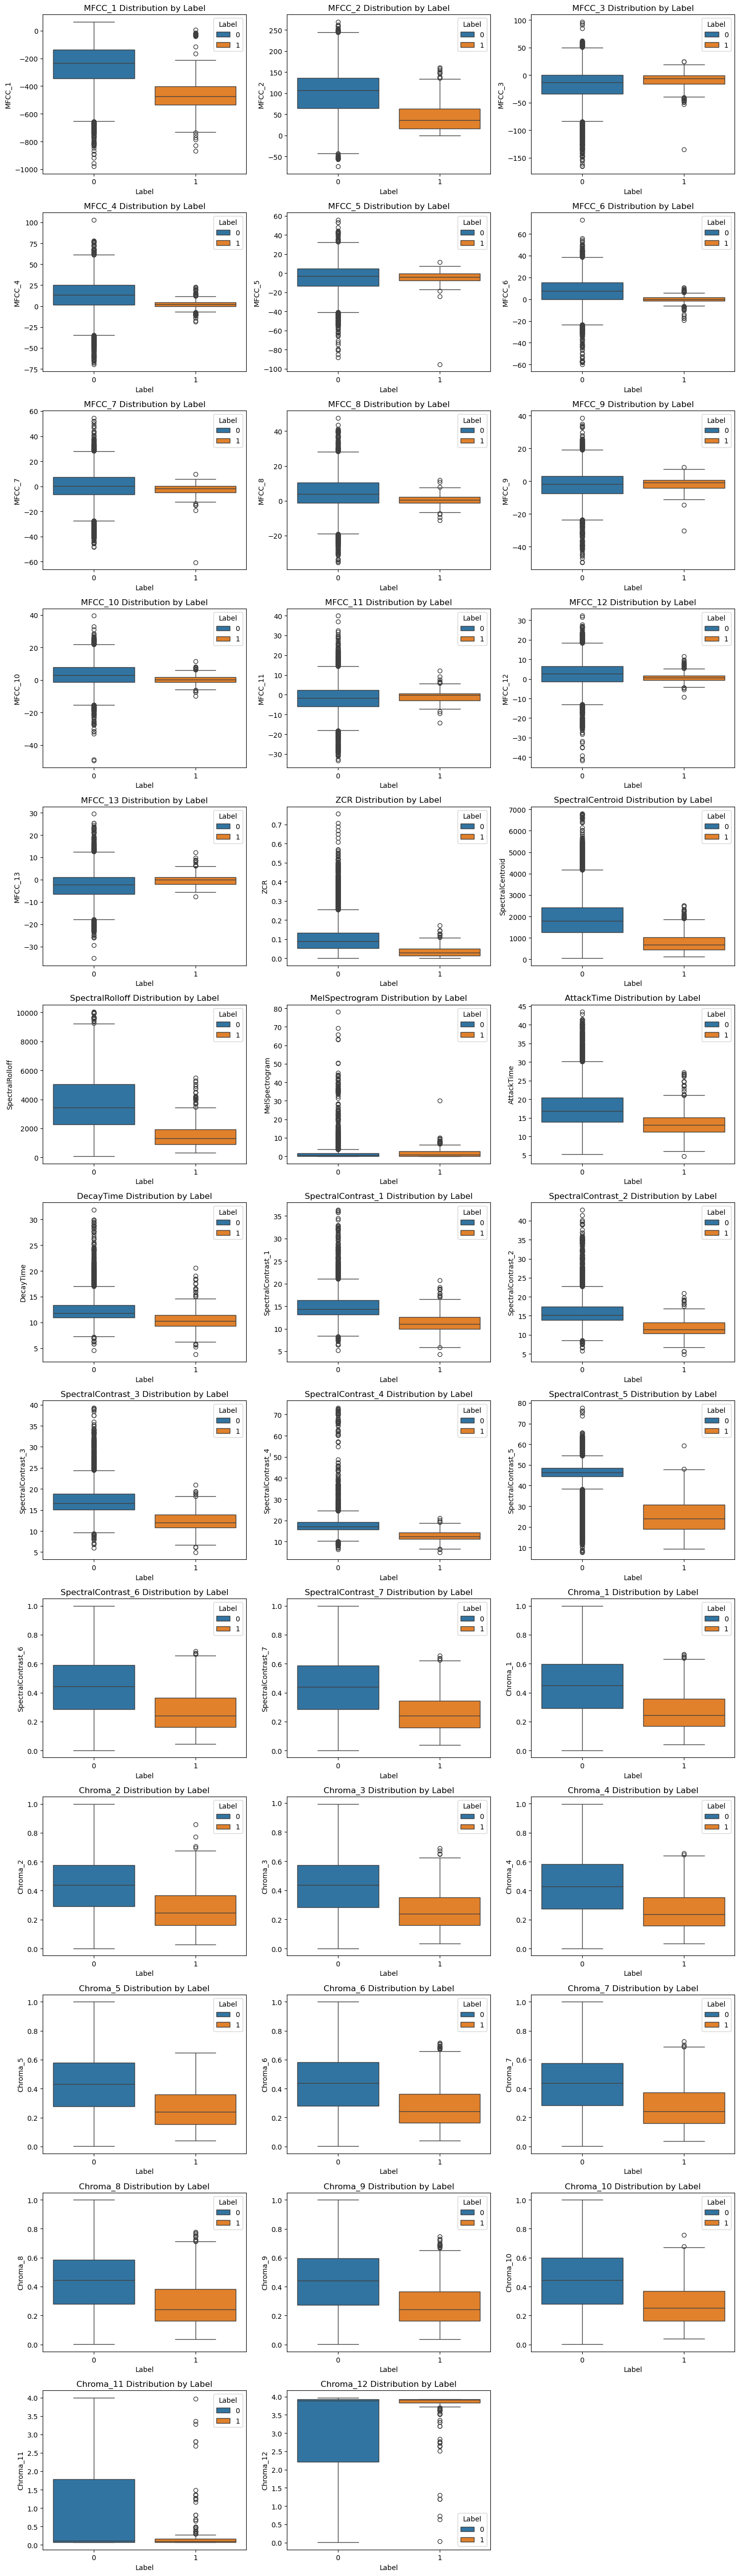

In [8]:
# Function to compare feature distributions with boxplots
def plot_boxplots(df, features, n_cols=3, label_column='Label'):
    n_features = len(features)
    n_cols = n_cols
    n_rows = n_features // n_cols + (0 if n_features % n_cols == 0 else 1)
    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i+1)
        sns.boxplot(x=label_column, y=feature, data=df, hue=label_column, palette='tab10')
        plt.title(f'{feature} Distribution by {label_column}')
    plt.tight_layout()
    plt.show()

# Call the function
features = [col for col in features_df.columns if col != 'Label']
plot_boxplots(features_df, features, n_cols=3, label_column='Label')

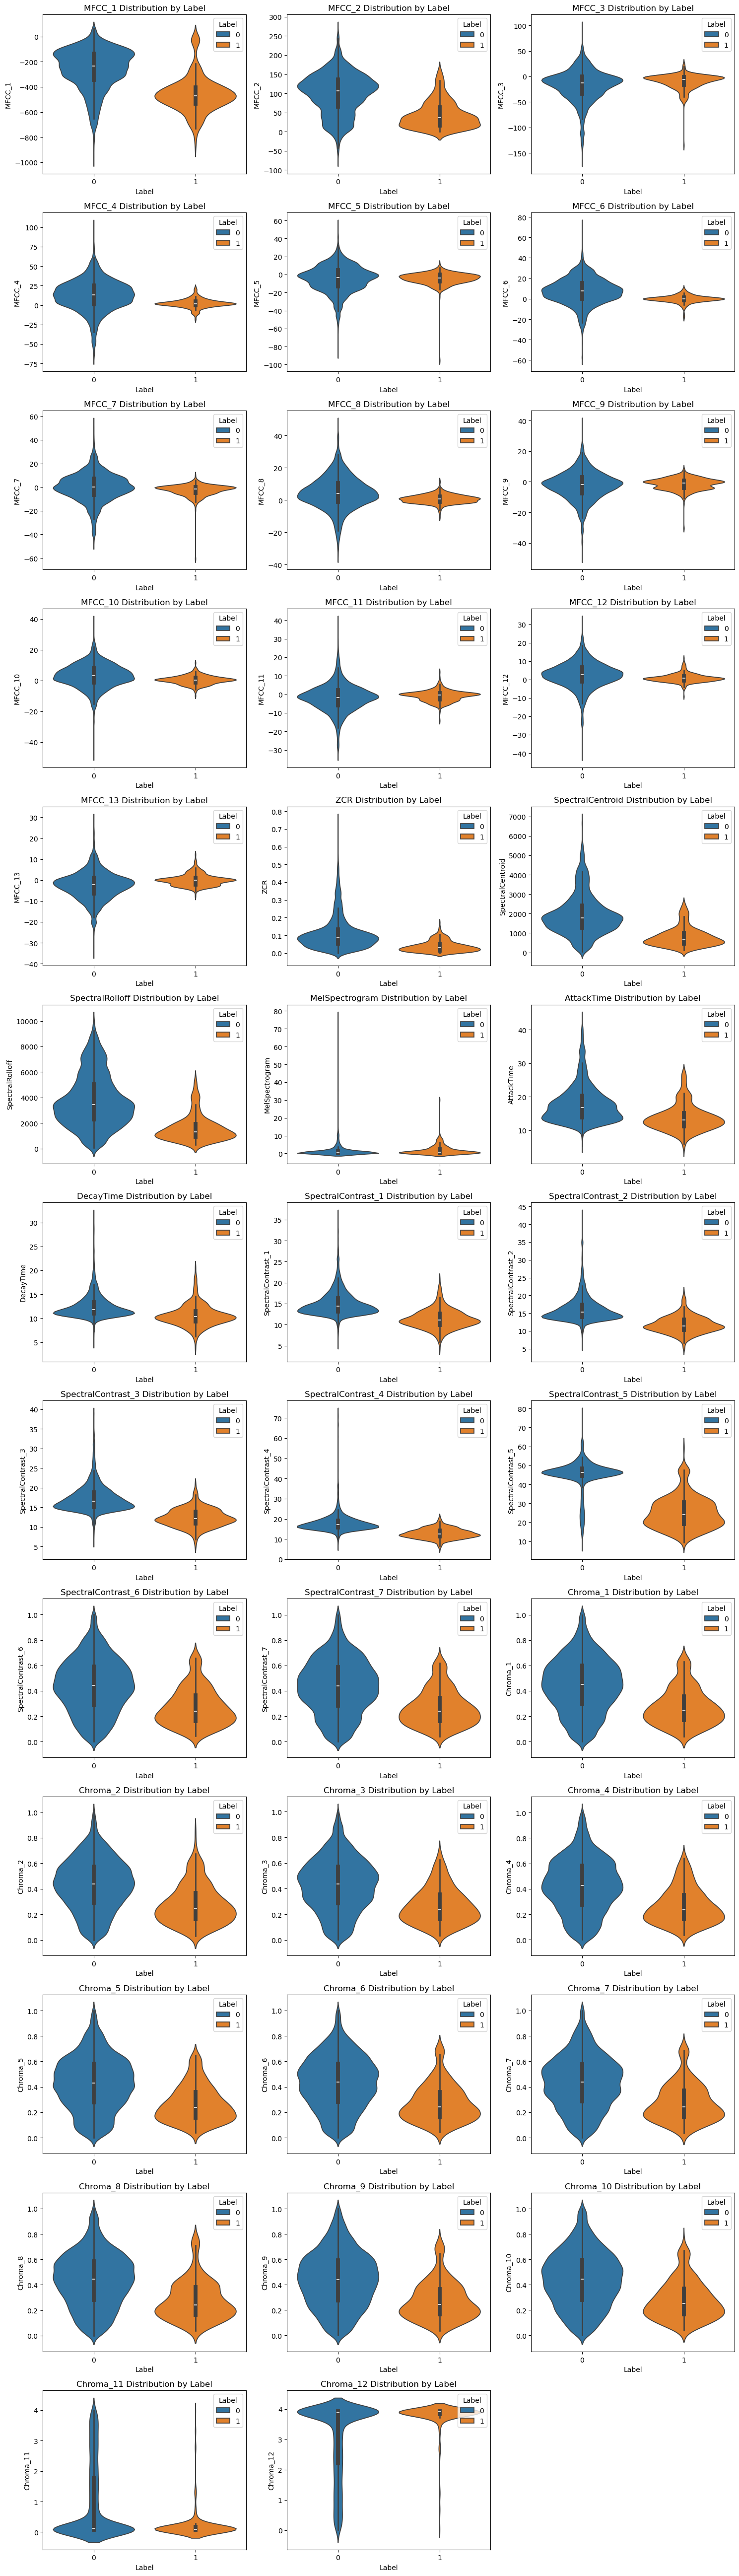

In [9]:
# Function to compare feature distributions with violin plots
def plot_violin(df, features, n_cols=3, label_column='Label'):
    n_cols = n_cols
    n_rows = len(features) // n_cols + (0 if len(features) % n_cols == 0 else 1)
    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i+1)
        sns.violinplot(x=label_column, y=feature, data=df, hue=label_column, palette='tab10')
        plt.title(f'{feature} Distribution by {label_column}')
    plt.tight_layout()
    plt.show()

# Call the function
features = [col for col in features_df.columns if col != 'Label']
plot_violin(features_df, features, n_cols=3, label_column='Label')

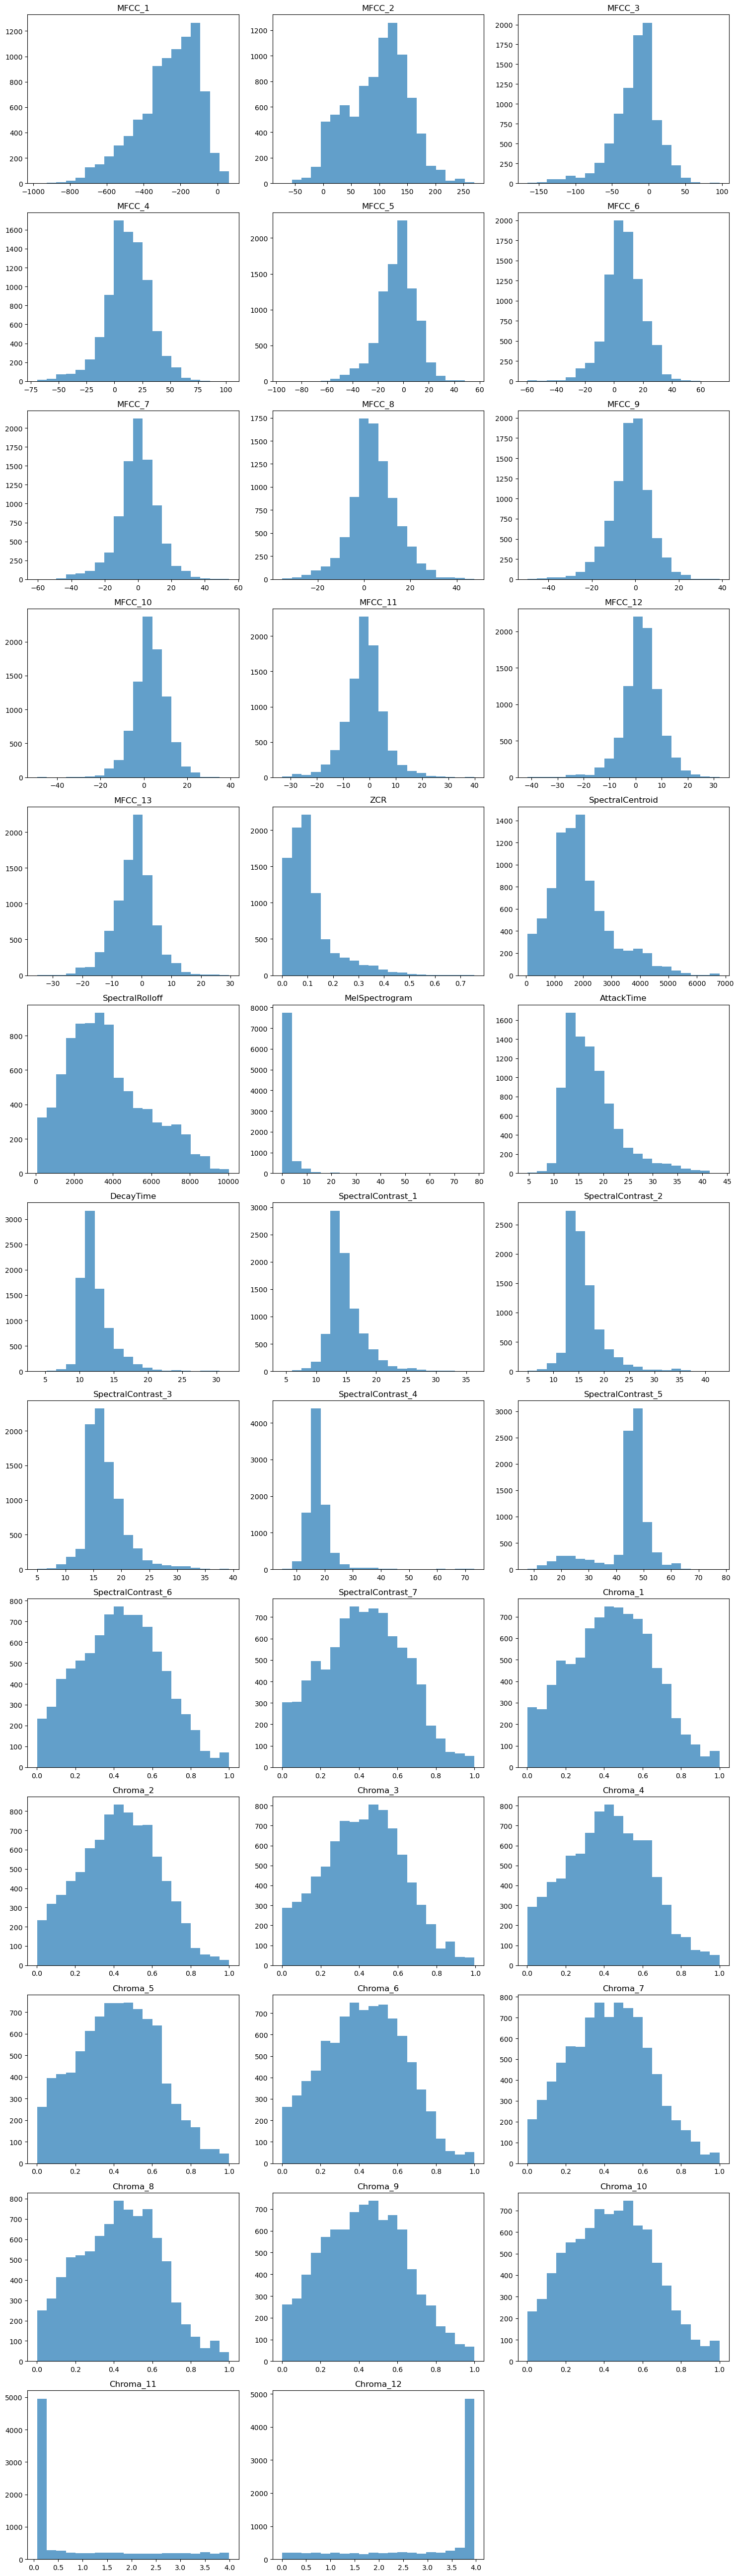

In [10]:
# Function to examine feature distributions with histograms
def plot_histograms(df, features, n_cols=3):
    n_cols = n_cols
    n_rows = len(features) // n_cols + (0 if len(features) % n_cols == 0 else 1)
    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(df[feature], bins=20, alpha=0.7)
        plt.title(feature)
    plt.tight_layout()
    plt.show()

# Call the function
features = [col for col in features_df.columns if col != 'Label']
plot_histograms(features_df, features, n_cols=3)

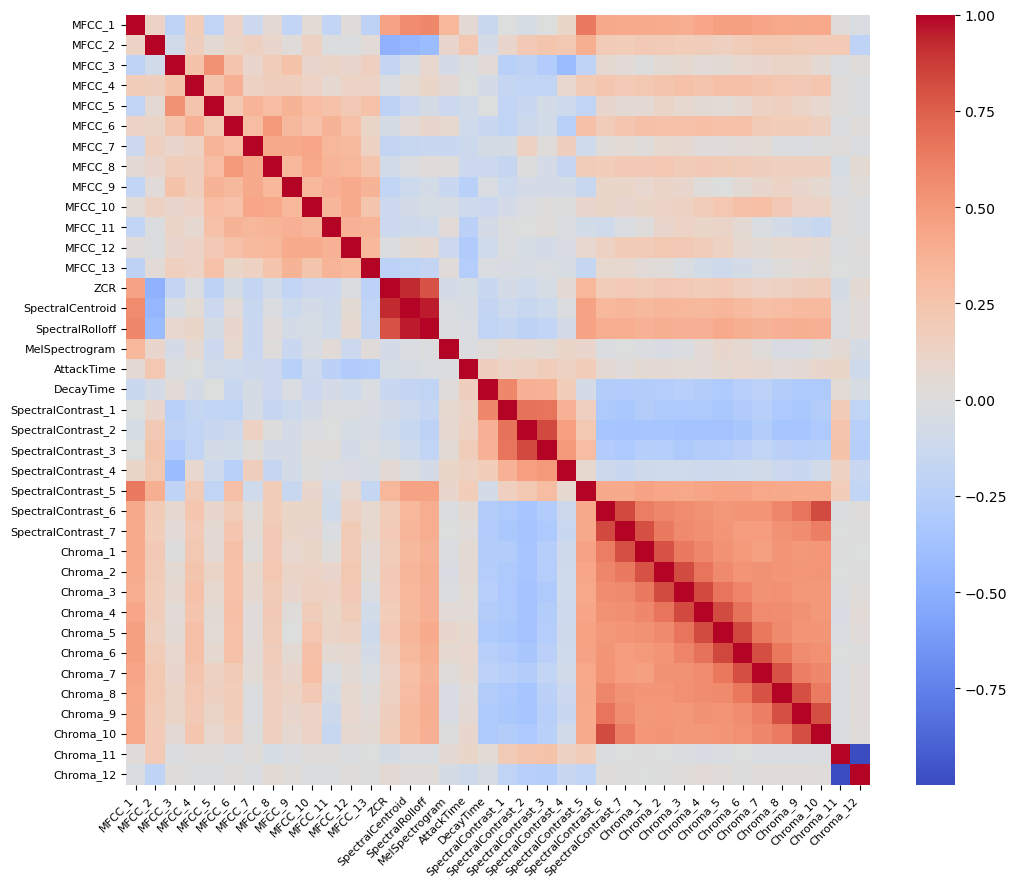

In [11]:
# Function to plot correlation heatmap
def plot_correlation_heatmap(df, features):
    corr_matrix = df[features].corr()
    plt.figure(figsize=(12, 10))
    heatmap = sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
    plt.xticks(rotation=45, ha='right')
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 8)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 8)
    plt.show()

# Call the function
features = [col for col in features_df.columns if col != 'Label']
plot_correlation_heatmap(features_df, features)

# Preparing the Data

In [12]:
# Split the data into features and labels
X = np.array([sample['features'] for sample in features_data])
y = np.array([sample['label'] for sample in features_data])

In [13]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [14]:
# Save datasets to Pickle files
train_data_path = '/home/sagemaker-user/train_data.pkl'
val_data_path = '/home/sagemaker-user/val_data.pkl'
test_data_path = '/home/sagemaker-user/test_data.pkl'

with open(train_data_path, 'wb') as f:
    pickle.dump((X_train, y_train), f)

with open(val_data_path, 'wb') as f:
    pickle.dump((X_val, y_val), f)

with open(test_data_path, 'wb') as f:
    pickle.dump((X_test, y_test), f)

# Uploading Data to S3

In [15]:
import boto3
import sagemaker

# Initialize a SageMaker session
boto_session = boto3.Session(region_name='us-west-1')
session = sagemaker.Session(boto_session=boto_session)

# Specify the default bucket
bucket = session.default_bucket()
prefix = 'sagemaker/active-shooter-detection'

# Function to upload a file to S3
def upload_file_to_s3(file_path, bucket, prefix):
    return session.upload_data(
        path=file_path,
        bucket=bucket,
        key_prefix=f"{prefix}/data"
    )

# Upload the datasets to S3
train_data_s3_path = upload_file_to_s3(train_data_path, bucket, prefix)
val_data_s3_path = upload_file_to_s3(val_data_path, bucket, prefix)
test_data_s3_path = upload_file_to_s3(test_data_path, bucket, prefix)

# Print out the S3 paths
print(f"Train data uploaded to: {train_data_s3_path}")
print(f"Validation data uploaded to: {val_data_s3_path}")
print(f"Test data uploaded to: {test_data_s3_path}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Train data uploaded to: s3://sagemaker-us-west-1-339712991889/sagemaker/active-shooter-detection/data/train_data.pkl
Validation data uploaded to: s3://sagemaker-us-west-1-339712991889/sagemaker/active-shooter-detection/data/val_data.pkl
Test data uploaded to: s3://sagemaker-us-west-1-339712991889/sagemaker/active-shooter-detection/data/test_data.pkl


# Training Script

In [16]:
%%writefile train.py

import argparse
import os
import joblib
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import keras

# Model function
def model_fn(model_dir):
    model_path = os.path.join(model_dir, 'audio_classifier')
    scaler_path = os.path.join(model_dir, 'scaler.joblib')

    model = keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Attach scaler as an attribute of the model
    model.scaler = scaler
    return model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # SageMaker parameters
    parser.add_argument('--output_data_dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train_data', type=str, default=os.environ['SM_CHANNEL_TRAIN'] + '/train_data.pkl')
    parser.add_argument('--val_data', type=str, default=os.environ['SM_CHANNEL_VALIDATION'] + '/val_data.pkl')
    parser.add_argument('--test_data', type=str, default=os.environ['SM_CHANNEL_TEST'] + '/test_data.pkl')

    # Model configuration parameters
    parser.add_argument('--activation', type=str, default='relu')
    parser.add_argument('--dropout_rate', type=float, default=0.12680826948356516)
    parser.add_argument('--units_layer1', type=int, default=145)
    parser.add_argument('--units_layer2', type=int, default=134)
    parser.add_argument('--units_layer3', type=int, default=506)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--optimizer', type=str, default='adam')
    parser.add_argument('--learning_rate', type=float, default=0.0016138352830732965)

    args = parser.parse_args()

    # Load datasets
    with open(args.train_data, 'rb') as f:
        X_train, y_train = pickle.load(f)
    with open(args.val_data, 'rb') as f:
        X_val, y_val = pickle.load(f)
    with open(args.test_data, 'rb') as f:
        X_test, y_test = pickle.load(f)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # TensorFlow Datasets
    # Tensor conversion
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))

    # Shuffling training set
    train_ds = train_ds.shuffle(buffer_size=len(X_train_scaled), reshuffle_each_iteration=True)

    # Batching and prefetching
    train_ds = train_ds.batch(args.batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(args.batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(args.batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Function to build the model
    def create_model(input_shape, activation, dropout_rate, units_layer1, units_layer2, units_layer3, learning_rate):
        model = keras.Sequential([
            keras.Input(shape=(input_shape,)),
            keras.layers.Dense(units_layer1, activation=activation),
            keras.layers.Dropout(dropout_rate),
            keras.layers.Dense(units_layer2, activation=activation),
            keras.layers.Dropout(dropout_rate),
            keras.layers.Dense(units_layer3, activation=activation),
            keras.layers.Dropout(dropout_rate),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        # Dynamically choose optimizer
        if args.optimizer.lower() == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif args.optimizer.lower() == 'sgd':
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        elif args.optimizer.lower() == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")

        # Compile the model
        model.compile(loss='binary_crossentropy',
                      metrics=['accuracy', keras.metrics.Recall(name='recall'), keras.metrics.Precision(name='precision')],
                      optimizer=optimizer)

        return model

    # Build the model
    model = create_model(
        X_train_scaled.shape[1],
        args.activation,
        args.dropout_rate,
        args.units_layer1,
        args.units_layer2,
        args.units_layer3,
        args.learning_rate,
    )

    # Set up callbacks
    checkpoint_path = 'best_model.tf'
    model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, mode='min', verbose=1)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

    # Calculate class weights
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    # Train the model
    history = model.fit(
        train_ds,
        epochs=args.epochs,
        validation_data=val_ds,
        class_weight=class_weights,
        callbacks=[model_checkpoint, reduce_lr, early_stopping],
        verbose=0
    )

    # Load the best model
    best_model = keras.models.load_model(checkpoint_path)

    # Save the model
    model_save_path = os.path.join('/opt/ml/model', 'audio_classifier', '1')
    best_model.save(model_save_path)

    # Save the scaler
    scaler_save_path = os.path.join('/opt/ml/model', 'scaler.joblib')
    joblib.dump(scaler, scaler_save_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy, test_recall, test_precision = best_model.evaluate(test_ds)
    
    # Print the evaluation results
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Recall: {test_recall}")
    print(f"Test Precision: {test_precision}")

Writing train.py


In [17]:
from sagemaker.tensorflow import TensorFlow

# Specify the SageMaker session
sagemaker_session = sagemaker.Session(boto_session=boto3.Session(region_name='us-west-1'))
role = sagemaker.get_execution_role(sagemaker_session=sagemaker_session)

# Configure the training job
tf_estimator = TensorFlow(
    use_spot_instances=True,
    max_run=3600,
    max_wait=3600,
    entry_point='train.py',
    role=role,
    framework_version='2.12',
    py_version='py310',
    script_mode=True,
    sagemaker_session=sagemaker_session,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    requirements_file='requirements_sm.txt'
)

# Specify the S3 path to the data
data_channels = {
    'train': train_data_s3_path,
    'validation': val_data_s3_path,
    'test': test_data_s3_path
}

# Launch the training job
tf_estimator.fit(data_channels)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-02-29-07-49-02-327


Using provided s3_resource
2024-02-29 07:49:02 Starting - Starting the training job......
2024-02-29 07:49:36 Starting - Preparing the instances for training...
2024-02-29 07:50:30 Downloading - Downloading input data...
2024-02-29 07:50:56 Downloading - Downloading the training image......
2024-02-29 07:51:41 Training - Training image download completed. Training in progress.2024-02-29 07:51:50,412 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2024-02-29 07:51:50,413 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-29 07:51:50,414 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-02-29 07:51:50,774 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-29 07:51:50,774 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-02-29 07:51:50,786 sagemaker-training-toolkit INFO     No

# Downloading Artifacts

In [23]:
# Use the SageMaker Boto3 client
sagemaker_client = boto3.client('sagemaker', region_name='us-west-1')

# Get latest training job
tf_estimator.latest_training_job.wait(logs='None')

# Get the name of the latest training job
training_job_name = tf_estimator.latest_training_job.name

# Describe the training job to get the model artifacts' S3 path
artifact_description = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
model_artifacts_s3_path = artifact_description['ModelArtifacts']['S3ModelArtifacts']

print(f"Model artifact persisted at {model_artifacts_s3_path}")


2024-02-29 07:53:57 Starting - Preparing the instances for training
2024-02-29 07:53:57 Downloading - Downloading the training image
2024-02-29 07:53:57 Training - Training image download completed. Training in progress.
2024-02-29 07:53:57 Uploading - Uploading generated training model
2024-02-29 07:53:57 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-west-1-339712991889/tensorflow-training-2024-02-29-07-49-02-327/output/model.tar.gz


In [27]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify bucket name and object key
bucket_name = 'sagemaker-us-west-1-339712991889'
object_key = 'tensorflow-training-2024-02-29-07-49-02-327/output/model.tar.gz'
local_file_name = 'model.tar.gz'

# Download the file
s3.download_file(bucket_name, object_key, local_file_name)

print(f"Downloaded {object_key} from bucket {bucket_name} to {local_file_name}")

Downloaded tensorflow-training-2024-02-29-07-49-02-327/output/model.tar.gz from bucket sagemaker-us-west-1-339712991889 to model.tar.gz


In [28]:
import tarfile

# Extract the model.tar.gz file
with tarfile.open(local_file_name, "r:gz") as tar:
    tar.extractall()
    print("Extracted the model artifact.")

# List the contents of the extracted directory
!ls -lR

Extracted the model artifact.
.:
total 8592
-rw-r--r-- 1 sagemaker-user users  254060 Feb 29 04:14 7060-6-0-0_gun_shot.wav
drwxr-xr-x 3 sagemaker-user users      15 Feb 29 07:53 audio_classifier
-rw-r--r-- 1 sagemaker-user users 3030570 Feb 29 02:42 features_data.pkl
-rw-r--r-- 1 sagemaker-user users 2385251 Feb 29 09:05 gunshot_audio_classification_sagemaker.ipynb
-rw-r--r-- 1 sagemaker-user users  371831 Feb 29 09:05 model.tar.gz
-rw-r--r-- 1 sagemaker-user users    1527 Feb 29 07:53 scaler.joblib
-rw-r--r-- 1 sagemaker-user users    3596 Feb 29 08:53 serve.py
-rw-r--r-- 1 sagemaker-user users  272920 Feb 29 07:48 test_data.pkl
-rw-r--r-- 1 sagemaker-user users    6319 Feb 29 07:49 train.py
-rw-r--r-- 1 sagemaker-user users 2179552 Feb 29 07:48 train_data.pkl
-rw-r--r-- 1 sagemaker-user users  272608 Feb 29 07:48 val_data.pkl

./audio_classifier:
total 0
drwxr-xr-x 4 sagemaker-user users 106 Feb 29 07:53 1

./audio_classifier/1:
total 156
drwxr-xr-x 2 sagemaker-user users      6 Feb 

# Inference Script

In [61]:
%%writefile serve.py

from flask import Flask, request, jsonify
import io
import os
import numpy as np
import librosa
import tensorflow as tf
import keras
import joblib

app = Flask(__name__)

# Initialize model and scaler to None
model = None
scaler = None

def load_model_and_scaler():
    global model, scaler
    # Set the model and scaler paths within the Docker container
    model_path = '/app/audio_classifier/1'
    scaler_path = '/app/scaler.joblib'
    
    if model is None:
        model = keras.models.load_model(model_path)
    if scaler is None:
        scaler = joblib.load(scaler_path)

@app.route('/ping', methods=['GET'])
def ping():
    # Check if the model was loaded correctly
    load_model_and_scaler()
    status = 200 if model and scaler else 404
    return '', status

# Function to pad the audio
def pad_audio_to_length(audio, target_length, sr):
    current_length = len(audio)
    target_length_samples = int(target_length * sr)
    if current_length < target_length_samples:
        pad_length = target_length_samples - current_length
        padded_audio = np.pad(audio, (0, pad_length), mode='constant')
    else:
        padded_audio = audio
    return padded_audio

# Function to preprocess and extract features
def extract_features(audio, sr, target_length=4.0, n_mfcc=13, n_fft=2048, hop_length=512):
    audio = pad_audio_to_length(audio, target_length, sr)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = np.mean(mfccs, axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=22050, n_fft=n_fft, hop_length=hop_length))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=22050, n_fft=n_fft, hop_length=hop_length))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=22050, n_fft=n_fft, hop_length=hop_length), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=22050, n_fft=n_fft, hop_length=hop_length), axis=1)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=n_fft, hop_length=hop_length))

    # Calculate onset envelope and temporal features
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    attack_time = np.argmax(onset_env) * hop_length / sr
    decay_time = len(audio) / sr - attack_time

    features_vector = np.concatenate([
        mfccs_mean,
        [zcr, spectral_centroid, spectral_rolloff, mel_spectrogram],
        spectral_contrast,
        chroma,
        [attack_time, decay_time]
    ])
    return features_vector.reshape(1, -1)

@app.route('/invocations', methods=['POST'])
def predict():
    if request.content_type == 'audio/wav':
        audio_buffer = io.BytesIO(request.data)
        audio, sr = librosa.load(audio_buffer, sr=None)
        features = extract_features(audio, sr)
        features_scaled = scaler.transform(features)
        prediction = model.predict(features_scaled)
        predicted_class = (prediction > 0.4).astype(int)
        message = "Threat detected." if predicted_class[0][0] == 1 else "No threat detected."
        return jsonify({'message': message})
    else:
        raise ValueError("Unsupported content type: " + request.content_type)

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=int(os.environ.get("PORT", 8080)))

Writing serve.py


# Endpoint Creation

In [63]:
# Specify region, ECR image URI, and other details
region_name = 'us-west-1'
account_id = '339712991889'
image_uri = f'{account_id}.dkr.ecr.{region_name}.amazonaws.com/active-shooter-detector:latest'
model_name = 'audio-classifier-v16'
endpoint_config_name = 'audio-classifier-config-v16'
endpoint_name = 'audio-classifier-endpoint-v16'
sagemaker_role_arn = 'arn:aws:iam::339712991889:role/service-role/AmazonSageMaker-ExecutionRole-20240228T174614'

sagemaker_client = boto3.client('sagemaker', region_name=region_name)

# Create a SageMaker model
create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        'Image': image_uri,
    },
    ExecutionRoleArn=sagemaker_role_arn
)

# Create an endpoint configuration
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTraffic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m6g.xlarge',
        },
    ]
)

# Create the endpoint
create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

print(f"Endpoint ARN: {create_endpoint_response['EndpointArn']}")

Endpoint ARN: arn:aws:sagemaker:us-west-1:339712991889:endpoint/audio-classifier-endpoint-v16


In [65]:
# Check the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
print(response['EndpointStatus'])

InService


# Endpoint Invocation

In [66]:
import json

# Initialize the boto3 client
client = boto3.client('runtime.sagemaker', region_name=region_name)

# Specify the path to .wav file
wav_file_path = '/home/sagemaker-user/7060-6-0-0_gun_shot.wav'

# Function to load and send the audio file
def invoke_endpoint_with_audio_file(file_path, endpoint_name):
    with open(file_path, 'rb') as f:
        payload = f.read()

    # Invoke the SageMaker endpoint
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='audio/wav',
        Body=payload
    )

    # Parse the response
    result = json.loads(response['Body'].read().decode())
    return result

# Invoke the endpoint with the audio file
result = invoke_endpoint_with_audio_file(wav_file_path, endpoint_name)
print(result)

{'message': 'Threat detected.'}


# Endpoint Cleanup

In [67]:
# Initialize the SageMaker client
sagemaker = boto3.client('sagemaker', region_name=region_name)

# Delete the endpoint
sagemaker.delete_endpoint(EndpointName=endpoint_name)

print(f"Endpoint {endpoint_name} deleted successfully.")

Endpoint audio-classifier-endpoint-v16 deleted successfully.
